### Gaussian propagation
Based on the practitioners guide, we first simulate a focussed gaussian field in the Crank-Nicolson scheme, the fourier scheme and the analytical solution for quanitfying the accuracies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
from crank_nicolson import time_independent 

import importlib
importlib.reload(time_independent)
pass

### Crank-Nicolson
Practitioners guide page 41.

In [12]:
grid = time_independent.Grid()
grid.generate_radial_grid(N = 1024, r_min = 0, r_max = 0.1)
grid.generate_propagation_grid(N = 1024*4, z_0=0, z_max=0.4)

In [13]:
# all units in mm
omega_0 = 0.01 # beam waist
lamb = 1030e-6 # wavelength
f = 0.2 # focal length of lense
n0 = 1.5 # refrective index
k0 = n0 * 2 * np.pi / lamb

# stability?
print('stable when %.2Ef << %.2E:   '%(grid.Delta_z, k0*grid.Delta_r**2), 1/(grid.Delta_z / (k0*grid.Delta_r**2)))

stable when 9.77E-05f << 8.73E-05:    0.8935810414867812


In [14]:
propagator = time_independent.Propagator(grid)
propagator.generate_L_matrices(k0)
propagator.apply_boundry_to_L_matrices()
propagator.invert_L_minus()
propagator.generate_L_matrix()

In [15]:
### initial condition
E_0 = 1
E_init = E_0 * np.exp(- grid.r**2 / omega_0**2 - 1j * k0 * grid.r**2 / (2*f))

if False:
    plt.plot(grid.r, np.abs(E_init)**2)
    plt.axis([0,0.2,0,1])
    plt.show()

In [16]:
E_final = np.zeros([grid.N_perpendicular + 1, grid.N_z], dtype=np.clongdouble)
E_final[:,0] = E_init

for n in range(1, grid.N_z):
    E_final[:,n] = np.dot(propagator.L, E_final[:,n-1])

C:\Users\L\AppData\Local\Temp\ipykernel_4132\3066001368.py:1: RuntimeWarning: overflow encountered in absolute
  I_final = np.abs(E_final)**2
C:\Users\L\AppData\Local\Temp\ipykernel_4132\3066001368.py:1: RuntimeWarning: overflow encountered in square
  I_final = np.abs(E_final)**2


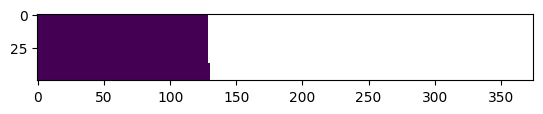

In [17]:
I_final = np.abs(E_final)**2
plt.imshow(I_final[:50,:750:2])


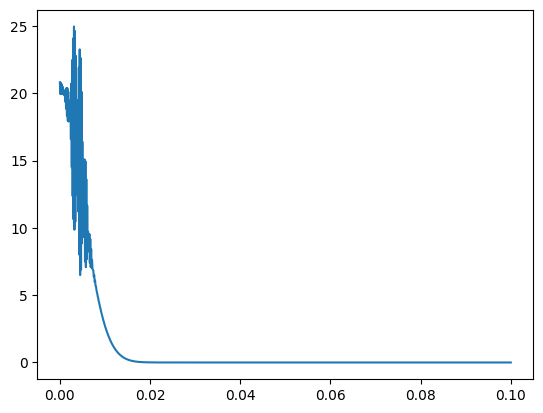

In [20]:
plt.plot(grid.r, I_final[:,6])

### Analytical solution
Page 39 in practitioners guide

C:\Users\L\AppData\Roaming\Python\Python312\site-packages\matplotlib\transforms.py:2855: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


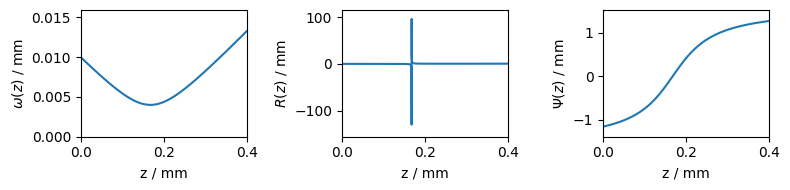

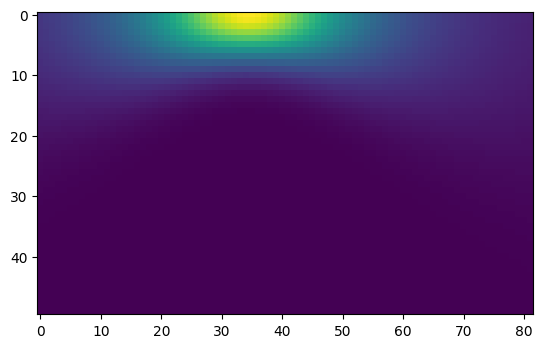

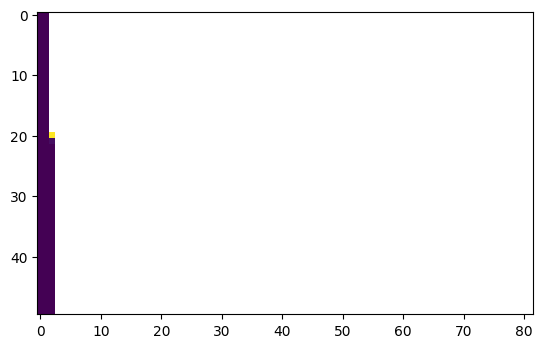

In [9]:
def analytical_w(z):
    a = (1-z/f)**2
    z_R = k0*omega_0**2/2
    b = z**2/z_R**2
    return omega_0*(a + b)**0.5

def analytical_R(z):
    z_R = k0*omega_0**2/2
    df = f/(1+f**2/z_R**2)
    return z-df + (df * (f - df)) / (z - df)

def analytical_Psi(z):
    z_R = k0*omega_0**2/2
    df = f/(1+f**2/z_R**2)
    return np.arctan((z-df) / (f*df-df**2)**0.5)

fig, axarr = plt.subplots(1,3, figsize=[8,2])
axarr[0].plot(grid.z, analytical_w(grid.z))
axarr[0].axis([grid.z_0, grid.z_max, grid.r_min, analytical_w(grid.z).max()*1.2])
axarr[0].set_xlabel('z / mm')
axarr[0].set_ylabel(r'$\omega(z)$ / mm')

axarr[1].plot(grid.z, analytical_R(grid.z))
axarr[1].axis([grid.z_0, grid.z_max, analytical_R(grid.z).min()*1.2, analytical_R(grid.z).max()*1.2])
axarr[1].set_xlabel('z / mm')
axarr[1].set_ylabel(r'$R(z)$ / mm')

axarr[2].plot(grid.z, analytical_Psi(grid.z))
axarr[2].axis([grid.z_0, grid.z_max, analytical_Psi(grid.z).min()*1.2, analytical_Psi(grid.z).max()*1.2])
axarr[2].set_xlabel('z / mm')
axarr[2].set_ylabel(r'$\Psi(z)$ / mm')


plt.tight_layout()
plt.show()

def analytical_E(r,z):
    a = E_0* omega_0 / analytical_w(z)
    b = r**2 / analytical_w(z)**2
    c = 1j * k0 * r**2 / (2 * analytical_R(z))
    d = 1j * analytical_Psi(z)

    return a * np.exp(-b +c -d)

E_analytical_final = analytical_E(*np.meshgrid(grid.r,grid.z)).T
I_analytical_final = np.abs(E_analytical_final)**2
plt.imshow(I_analytical_final[:50,::50])
plt.show()

plt.imshow(I_final[:50,::50])
plt.show()

max error: nan percent


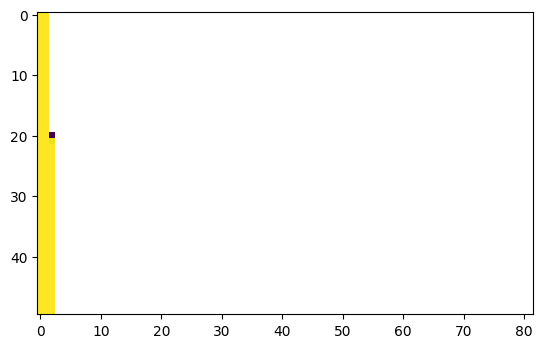

In [10]:
difference = I_analytical_final[:50,::50] -  I_final[:50,::50] 
print('max error: %.1f percent'%(np.max(difference) / I_analytical_final[:50,::50].max() * 100))
plt.imshow(difference)
plt.show()